In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
import time
from collections import Counter
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score,confusion_matrix,classification_report

from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPooling2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.preprocessing import image as IMG

import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs

2022-08-05 23:58:03.645430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-05 23:58:03.645476: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Dataset A - All publishers

In [2]:
with open('image_data_array.pickle','rb') as file:
    data = pickle.load(file)

In [3]:
X_train, X_test,X_val,y_train,y_test,y_val = data[0],data[1],data[2],data[3],data[4],data[5]

y_train_hotcode = keras.utils.to_categorical(y_train)
y_val_hotcode = keras.utils.to_categorical(y_val)
y_test_hotcode = keras.utils.to_categorical(y_test)

In [4]:
IMGgen = IMG.ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


train_ds = IMGgen.flow(X_train, y_train, batch_size=32)
val_ds = IMGgen.flow(X_val, y_val, batch_size=16)

**Transfer Learning with Xception**

Freeze Xception parameter and exclude top layers

In [8]:
Xception_base = keras.applications.Xception(weights="imagenet", 
                                            input_shape=(150, 150, 3),
                                            include_top=False) 

Xception_base.trainable = False

In [6]:
if os.path.exists("model_h5_file/Xception_model_array.h5") == False:
    

    inputs = keras.Input(shape=(150, 150, 3))
    
    x = keras.applications.xception.preprocess_input(inputs)
    x = Xception_base(x, training=False)
    
    x = Flatten()(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(4)(x)
    Xception = keras.Model(inputs, outputs)

    Xception.summary()



    Xception.compile(
        #loss='categorical_crossentropy',
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        #optimizer= keras.optimizers.Adam(learning_rate=0.01),
        optimizer = 'Adam',
        metrics=['accuracy'],
    )



    Xception_result = Xception.fit(train_ds,
                                validation_data= val_ds,
                                epochs=30, verbose=1, 
                                callbacks = keras.callbacks.EarlyStopping(patience=5))  # track progress as we fit

    time2 = time.time()
    Xception.save("model_h5_file/Xception_model_array.h5")
    with open('Xception_result.pickle','wb')as file:
        pickle.dump(Xception_result, file)

else: 
    Xception = keras.models.load_model('model_h5_file/Xception_model_array.h5')
        
    with open('Xception_result.pickle','rb') as file:
        Xception_result = pickle.load(file)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 32)                163843

2022-07-26 08:33:01.177746: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://531742f1-9152-4ea1-8933-48f77f582cfa/assets


In [9]:
Xception= keras.models.load_model('model_h5_file/Xception_model_array.h5')
y_pred = np.argmax(Xception.predict(X_test),axis =1)

In [10]:
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.4106203995793901
recall : 0.3684547166579073
precision : 0.42719129784719206
f1 : 0.3457455107867748


In [11]:
category_int_map = {'spiegel': 1, 'zeit': 3, 'faz': 0, 'sz': 2}
int_category_map = {1: 'spiegel', 3:'zeit', 0:'faz', 2:'sz'}

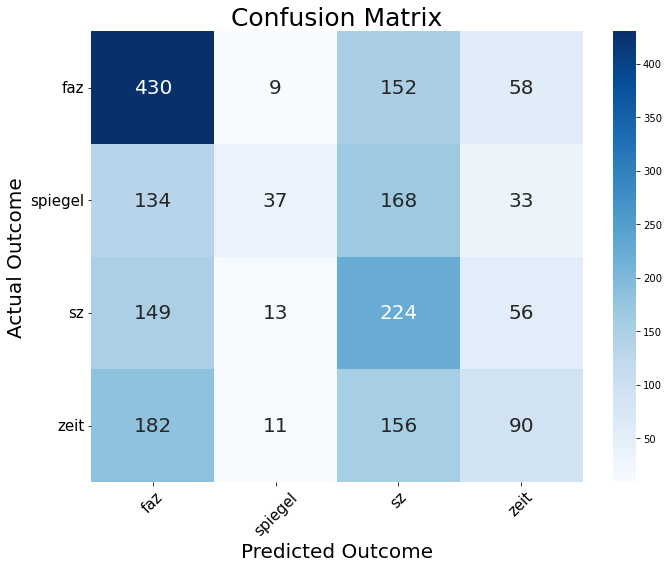

In [12]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

Train Xception parameters

In [13]:
if os.path.exists('model_h5_file/Xception_model_array_trainable.h5') == False:
    Xception_base.trainable = True
    Xception.summary()

    Xception.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    
    Xception_base_trainable_result = Xception.fit(train_ds,
                                                 validation_data= val_ds, 
                                                  epochs=20, 
                                                  verbose=1,
                                                  batch_size =32,
                                                 callbacks = keras.callbacks.EarlyStopping(patience=2) )  # track progress as we fit
    Xception.save("model_h5_file/Xception_model_array_trainable.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 32)                163843

In [14]:
y_pred = np.argmax(Xception.predict(X_test),axis =1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.41798107255520506
recall : 0.40167648262609373
precision : 0.4009334974498909
f1 : 0.39713392307071793


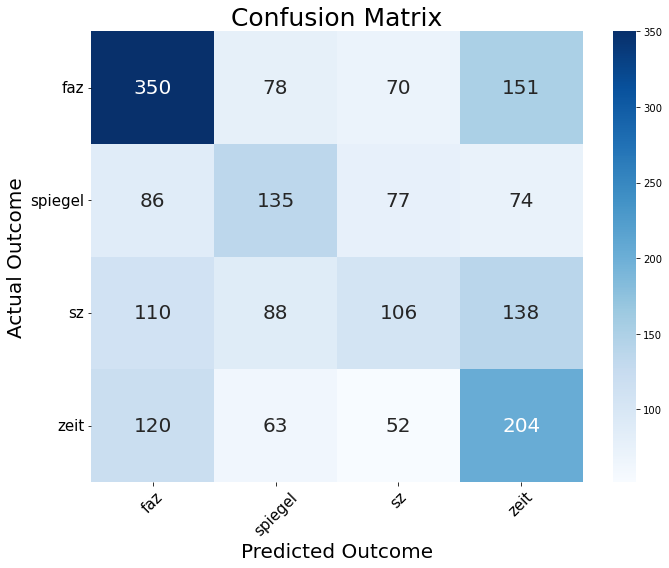

In [15]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

In [16]:
X_incorrect = X_test[y_test != y_pred]
y_pred_incorrect = y_pred[y_test != y_pred]
y_test_incorrect = y_test[y_test != y_pred]
len(X_incorrect)

1107

In [17]:
df = pd.read_csv("work_data_df",index_col = 0 )
df_test = df[df['class'] == "test"] 
pred_cate = [int_category_map.get(i) for i in y_pred]
df_test['pred_cate'] = pred_cate
df_test_incorrect = df_test[df_test.category != df_test.pred_cate]
df_test_incorrect

/tmp/ipykernel_17514/3250642109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_cate'] = pred_cate


,image_path,category,class,pred_cate
1902,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,test,faz
1903,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,test,sz
1904,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,test,faz
1905,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,test,sz
1906,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,test,sz
...,...,...,...,...
3799,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_sz,test,sz
3800,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_sz,test,faz
3801,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_sz,test,spiegel
3802,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_sz,test,faz


**Transfer Learning with VGG16**

In [9]:
vgg16_base = keras.applications.vgg16.VGG16(
                                            include_top= False, 
                                            weights='imagenet', 
                                            input_shape= (150,150,3))

Freeze VGG16 parameters and exclude top layers

In [14]:
if os.path.exists("model_h5_file/vgg16_model_array.h5") == False:
    
    vgg16_base.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    x = keras.applications.vgg16.preprocess_input(inputs)
    x = vgg16_base(x, training=False)

    x = Flatten()(x)
    x = keras.layers.Dense(64)(x)
    x = keras.layers.Dropout(0.1)(x)  # Regularize with dropout
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.1)(x)
    outputs = keras.layers.Dense(4)(x)
    vgg16 = keras.Model(inputs, outputs)

    vgg16.summary()
   
    vgg16.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits= True),
        optimizer = 'Adam',
        metrics=['accuracy'],
    )

    vgg16_result = vgg16.fit(train_ds,
                                validation_data= val_ds,
                                epochs=30, 
                                verbose=1,
                                batch_size =32,
                                callbacks = keras.callbacks.EarlyStopping(patience=5)) 

    vgg16.save("model_h5_file/vgg16_model_array.h5")
    
#     with open('vgg16_result.pickle','wb')as file:
#         pickle.dump(vgg16_result, file)

else: 
    vgg16 = keras.models.load_model('model_h5_file/vgg16_model_array.h5')
        
#     with open('vgg16_result.pickle','rb') as file:
#         vgg16_result = pickle.load(file)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 150, 150, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                5243

In [15]:
vgg16 = keras.models.load_model('model_h5_file/vgg16_model_array.h5')

y_pred = np.argmax(vgg16.predict(X_test),axis=1)

In [16]:
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.43690851735015773
recall : 0.41238480199720795
precision : 0.40866354026840895
f1 : 0.40680226302342054


Train VGG16 parameters

In [18]:
if os.path.exists('model_h5_file/vgg16_model_array_trainable.h5') == False:

    vgg16_base.trainable = True
    vgg16.summary()

    vgg16.compile(
                optimizer=keras.optimizers.Adam(1e-6),  # Low learning rate
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
                )
    
    vgg16_result = vgg16.fit(train_ds, 
                         validation_data = val_ds,
                         epochs = 100,
                         callbacks = keras.callbacks.EarlyStopping(patience=5),
                         verbose =1,
                         batch_size = 32)
    vgg16.save('model_h5_file/vgg16_model_array_trainable.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 150, 150, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                5243

In [19]:
vgg16 = keras.models.load_model('model_h5_file/vgg16_model_array_trainable.h5')
y_pred = np.argmax(vgg16.predict(X_test),axis=1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.434279705573081
recall : 0.41469636400267207
precision : 0.4104334834564287
f1 : 0.409420458979619


**Transfer Learning with mobilenet_V2**

In [29]:
mobilnetv2_base = keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", 
                                            input_shape=(150, 150, 3),
                                            include_top=False) 

mobilnetv2_base.trainable = False


if os.path.exists("mobilnetv2_base_array-.h5") == False:
    
    inputs = keras.Input(shape=(150, 150, 3))
    
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = mobilnetv2_base(x, training=False)
    
    x = Flatten()(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(4)(x)
    mobilnetv2 = keras.Model(inputs,outputs)

    mobilnetv2.summary()



    mobilnetv2.compile(
        #loss='categorical_crossentropy',
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer= keras.optimizers.Adam(learning_rate=0.0005),
        #optimizer = 'Adam',
        metrics=['accuracy'],
    )



    mobilnetv2_result = mobilnetv2.fit(train_ds,
                                validation_data= val_ds,
                                epochs=100, 
                                verbose=1, 
                                callbacks = keras.callbacks.EarlyStopping(patience=5))  # track progress as we fit

    mobilnetv2.save("model_h5_file/mobilnetv2_base_array.h5")
    with open('mobilnetv2_base.pickle','wb')as file:
        pickle.dump(Xception_result, file)

else: 
    mobilnetv2 = keras.models.load_model('model_h5_file/mobilnetv2_base_array.h5')
        
    with open('mobilnetv2_base.pickle','rb') as file:
        mobilnetv2_result = pickle.load(file)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                           

NameError: name 'Xception_result' is not defined

In [30]:
y_pred = np.argmax(mobilnetv2.predict(X_test),axis =1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.4001051524710831
recall : 0.39700527118867657
precision : 0.40246936904637776
f1 : 0.38921615069138016


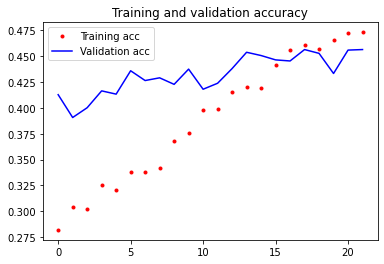

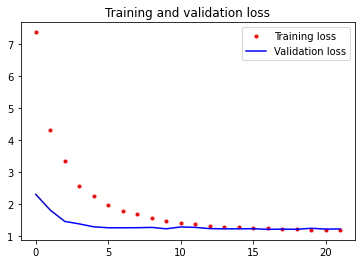

In [31]:
acc = mobilnetv2_result.history['accuracy']
val_acc = mobilnetv2_result.history['val_accuracy']
loss = mobilnetv2_result.history['loss']
val_loss = mobilnetv2_result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r.', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

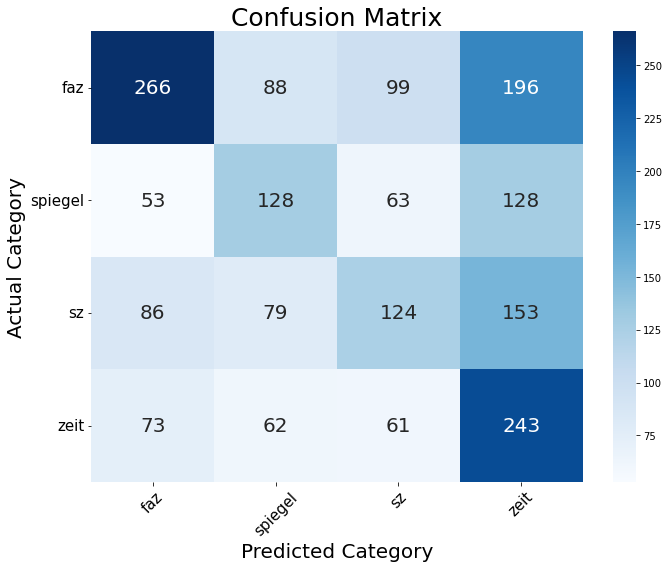

In [32]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Category', size=20)
plt.ylabel('Actual Category', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

Train mobilnetv2 parameters

In [33]:
if os.path.exists('model_h5_file/mobilnetv2_trainable_array.h5') == False:

    mobilnetv2_base.trainable = True
    mobilnetv2.summary()

    mobilnetv2.compile(
        #loss='categorical_crossentropy',
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer= keras.optimizers.Adam(learning_rate=0.001),
        #optimizer = 'Adam',
        metrics=['accuracy'],
    )
    
    mobilnetv2_result = mobilnetv2.fit(train_ds, 
                         validation_data = val_ds,
                         epochs = 100,
                         callbacks = keras.callbacks.EarlyStopping(patience=2),
                         verbose =1,
                         batch_size = 32)
    mobilnetv2.save('model_h5_file/mobilnetv2_trainable_array.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                           

In [34]:
y_pred = np.argmax(mobilnetv2.predict(X_test),axis =1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.3412197686645636
recall : 0.25
precision : 0.0853049421661409
f1 : 0.1272050176401411


/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Dataset B - FAZ (mid-right) and Spiegel (mid-left) (binary classification)

In [3]:
with open('image_data_array_fazsp.pickle','rb') as file:
    data = pickle.load(file)

In [4]:
X_train, X_test,X_val,y_train,y_test,y_val = data[0],data[1],data[2],data[3],data[4],data[5]

y_train_hotcode = keras.utils.to_categorical(y_train)
y_val_hotcode = keras.utils.to_categorical(y_val)
y_test_hotcode = keras.utils.to_categorical(y_test)

In [5]:
IMGgen = IMG.ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


train_ds = IMGgen.flow(X_train, y_train, batch_size=32)
val_ds = IMGgen.flow(X_val, y_val, batch_size=16)

**Transfer Learning with VGG16**

In [9]:
vgg16_base = keras.applications.vgg16.VGG16(
                                            include_top= False, 
                                            weights='imagenet', 
                                            input_shape= (150,150,3))

Freeze VGG16 parameters and exclude top layers

In [24]:
if os.path.exists("model_h5_file_fazsp/vgg16_model_array_fazsp.h5") == False:

    vgg16_base.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    x = keras.applications.vgg16.preprocess_input(inputs)
    x = vgg16_base(x, training=False)

    x = Flatten()(x)
    x = keras.layers.Dense(64)(x)
    x = keras.layers.Dropout(0.1)(x)  # Regularize with dropout
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Dropout(0.1)(x)
    
    outputs = keras.layers.Dense(2)(x)
    vgg16 = keras.Model(inputs, outputs)
    
    vgg16.summary()
   
    vgg16.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits= True),
        optimizer = 'Adam',
        metrics=['accuracy'],
    )

    vgg16_result = vgg16.fit(train_ds,
                                validation_data= val_ds,
                                epochs=30, 
                                verbose=1,
                                batch_size =32,
                                callbacks = keras.callbacks.EarlyStopping(patience=5)) 

    vgg16.save("model_h5_file_fazsp/vgg16_model_array_fazsp.h5")
    
#     with open('vgg16_result.pickle','wb')as file:
#         pickle.dump(vgg16_result, file)

else: 
    vgg16 = keras.models.load_model('model_h5_file_fazsp/vgg16_model_array_fazsp.h5')
        
#     with open('vgg16_result.pickle','rb') as file:
#         vgg16_result = pickle.load(file)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 150, 150, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                5243

In [6]:
vgg16 = keras.models.load_model('model_h5_file_fazsp/vgg16_model_array_fazsp.h5')

y_pred = np.argmax(vgg16.predict(X_test),axis=1)

#y_pred = np.argmax(vgg16.predict(test_ds),axis=1)

In [7]:
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.7335945151811949
recall : 0.7239011216594595
precision : 0.7154415164123902
f1 : 0.7184225041367899


Train VGG16 parameters

In [13]:
if os.path.exists('model_h5_file_fazsp/vgg16_model_array_trainable_fazsp.h5') == False:

    vgg16_base.trainable = True
    vgg16.summary()

    vgg16.compile(
                optimizer=keras.optimizers.Adam(1e-9),  # Low learning rate
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
                )
    
    vgg16_result = vgg16.fit(train_ds, 
                         validation_data = val_ds,
                         epochs = 100,
                         callbacks = keras.callbacks.EarlyStopping(patience=5),
                         verbose =1,
                         batch_size = 32)
    vgg16.save('model_h5_file_fazsp/vgg16_model_array_trainable_fazsp.h5')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 150, 150, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                5243

In [14]:
vgg16 = keras.models.load_model('model_h5_file_fazsp/vgg16_model_array_trainable_fazsp.h5')
y_pred = np.argmax(vgg16.predict(X_test),axis=1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.732615083251714
recall : 0.7237043756316583
precision : 0.7147540657680226
f1 : 0.7177916035983133


In [15]:
category_int_map = {'spiegel': 1, 'faz': 0}
int_category_map = {1: 'spiegel', 0:'faz'}

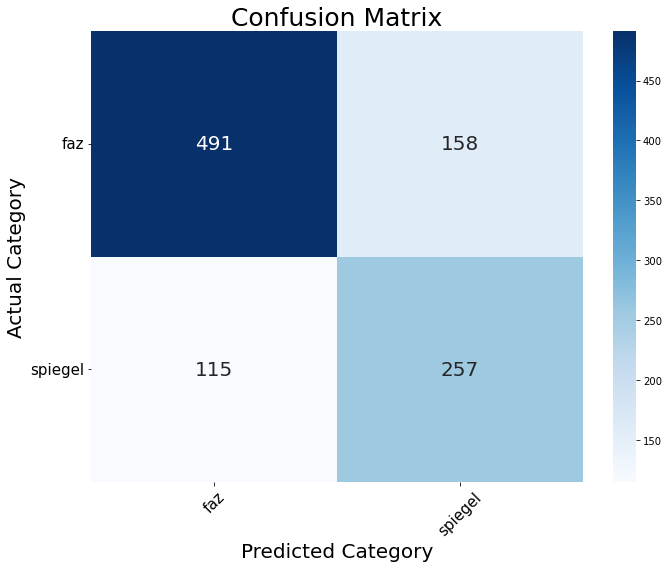

In [16]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Category', size=20)
plt.ylabel('Actual Category', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

In [17]:
work_data_df_test = pd.read_csv('work_data_df.csv')
work_data_df_test.drop(['Unnamed: 0'], axis=1, inplace=True)

y_test_adj = y_test.reset_index(drop=True)

work_data_df_test = pd.concat([work_data_df_test, y_test_adj, pd.Series(y_pred)], axis=1)
work_data_df_test.rename(columns={0: 'actual', 1: 'pred'}, inplace=True)
work_data_df_test['misclassification'] = work_data_df_test['actual'] == work_data_df_test['pred']

mistakes_faz = work_data_df_test.loc[(work_data_df_test['misclassification'] == False) & 
                                     (work_data_df_test['category'] == 'images_faz'), 'image_path']

mistakes_spiegel = work_data_df_test.loc[(work_data_df_test['misclassification'] == False) & 
                                     (work_data_df_test['category'] == 'images_spiegel'), 'image_path']


correct_faz = work_data_df_test.loc[(work_data_df_test['misclassification'] == True) & 
                                     (work_data_df_test['category'] == 'images_faz'), 'image_path']

correct_spiegel = work_data_df_test.loc[(work_data_df_test['misclassification'] == True) & 
                                     (work_data_df_test['category'] == 'images_spiegel'), 'image_path']

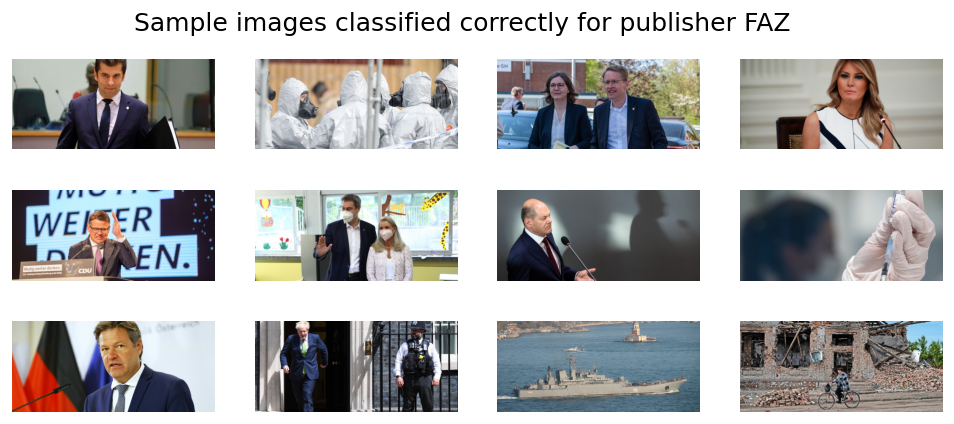

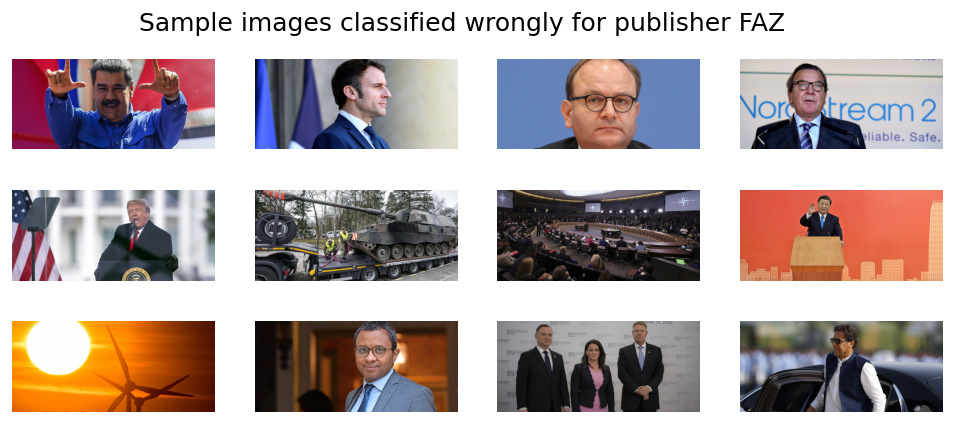

In [18]:
fig, ax = plt.subplots(3, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified correctly for publisher FAZ', fontsize=15)
fig.subplots_adjust(top=0.9)

for n,cate in enumerate(correct_faz[:12]):
    ax = plt.subplot(3,4,n+1)
    index = np.random.choice(correct_faz)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

fig, ax = plt.subplots(3, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified wrongly for publisher FAZ', fontsize=15)
fig.subplots_adjust(top=0.9)

for n,cate in enumerate(mistakes_faz[:12]):
    ax = plt.subplot(3,4,n+1)
    index = np.random.choice(mistakes_faz)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

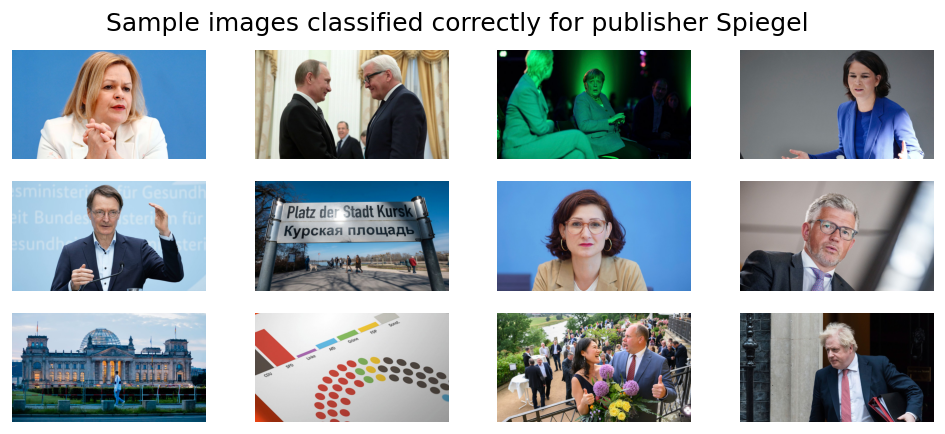

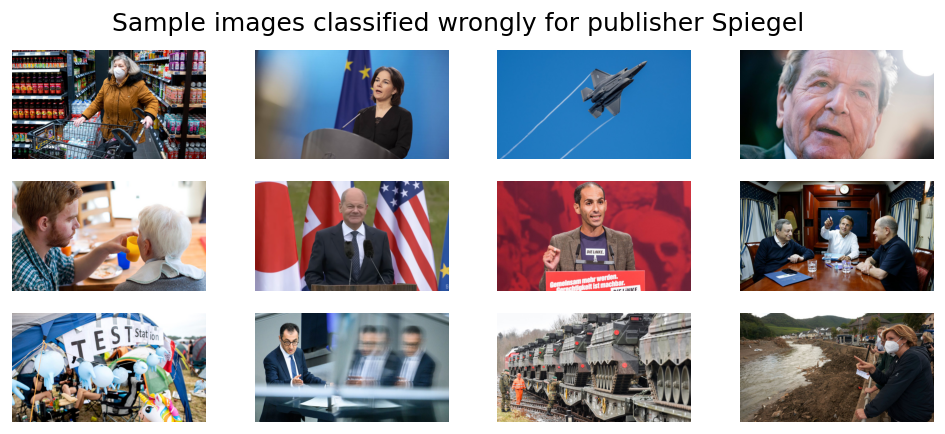

In [19]:
fig, ax = plt.subplots(3, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified correctly for publisher Spiegel', fontsize=15)
fig.subplots_adjust(top=0.9)

for n,cate in enumerate(correct_spiegel[:12]):
    ax = plt.subplot(3,4,n+1)
    index = np.random.choice(correct_spiegel)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

fig, ax = plt.subplots(3, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified wrongly for publisher Spiegel', fontsize=15)
fig.subplots_adjust(top=0.9)

for n,cate in enumerate(mistakes_spiegel[:12]):
    ax = plt.subplot(3,4,n+1)
    index = np.random.choice(mistakes_spiegel)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

## Dataset C - FAZ (mid-right) and Zeit (mid-left) (binary classification)

In [3]:
df_text = pd.read_csv('df_text.csv').drop('Unnamed: 0', axis=1)
df_text.dropna(inplace=True)
df_text['teaser'] = df_text.teaser.str.lower()
df_text.reset_index(drop=True, inplace=True)

In [4]:
df_text_prep = df_text.copy()
df_text_prep.publisher = df_text.publisher.map({'faz':0, 'zeit':1})
df_text_prep

,teaser,publisher
0,selenskyj skeptisch angesichts geplanter verha...,0
1,"die spd glaubt, sich ausreichend von gerhard s...",0
2,"dauernd hieß es, china sei die größte herausfo...",0
3,"der krieg in der ukraine wird zur folge haben,...",0
4,der russische überfall zeigt: das gas-projekt ...,0
...,...,...
4404,"ns-opfer, die wegen ihrer sexuellen und geschl...",1
4405,wegen steigender mieten und energiepreise soll...,1
4406,für die fahrer von mähmaschinen sind rehkitze ...,1
4407,erdoğan hat es geschafft: die ukraine und russ...,1


In [5]:
train, test = train_test_split(df_text_prep, test_size=0.2)

In [23]:
# define hyperparameter
train_args ={"reprocess_input_data": True,
             "fp16":False,
             "num_train_epochs": 2}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "distilbert-base-german-cased",
    num_labels=2,
    args=train_args,
    use_cuda=False
)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.2.output_layer_norm.bias', 'distilbert.transformer.layer.5.output_layer_norm.weight', 'distilbert.transformer.layer.3.ffn.lin1.bias', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.1.ffn.lin1.bias', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.3.output_layer_norm.bias', 'distilbert.transformer.layer.3.sa_layer_norm.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.2.output_layer_norm.weight', 'distilbert.transformer.layer.3.attention.out_lin.weight', 'distilbert.transformer.layer.5.attention.k_lin.weigh

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
